<a href="https://colab.research.google.com/github/jgraving/deepposekit/blob/master/examples/custom_data_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Use a custom data set with DeepPoseKit

This an example notebook for how to create your own data generator for using custom data with DeepPoseKit. We'll create a custom data generator with `deepposekit.io.BaseGenerator` using a toy dataset. You can modify this however you'd like to generate data from an arbitrary dataset.

**NOTE**: If you run into problems, you can help us improve DeepPoseKit by [opening an issue](https://github.com/jgraving/deepposekit/issues/new) or [submitting a pull request](https://help.github.com/en/articles/creating-a-pull-request-from-a-fork)


If you haven't already you can install DeepPoseKit by running the next cell:

In [ ]:
import sys
!{sys.executable} -m pip install -U deepposekit 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

from deepposekit.io import BaseGenerator, TrainingGenerator

/Users/jake/Library/Python/3.7/lib/python/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/jake/Library/Python/3.7/lib/python/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/jake/Library/Python/3.7/lib/python/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/jake/Library/Python/3.7/lib/python/site-packages/tensorflow/

Here we'll subclass `deepposekit.io.BaseGenerator` to create a toy example. This example is very simple, but you can use any arbitrary method for loading data within the class and make it as complex as you like. For example, pass `__init__()` the location of a text file and a list of image paths, and load them when you call `get_images` and `get_keypoints`.

Keep in mind that DeepPoseKit assumes **all images in the dataset are the same size/resolution**, and **the number of keypoints is the same** for all image-keypoints pairs. If a keypoint isn't visible, you should replace it's coordinates with `np.nan` and `BaseGenerator` will make sure the model is trained to predict a confidence map of zeros.

In [2]:
class ToyGenerator(BaseGenerator):
    """
    ToyGenerator class 
    uses deepposekit.io.BaseGenerator for abstracting data loading and saving.
    Attributes that should be defined before use:
    __init__
    __len__
    compute_image_shape
    compute_keypoints_shape
    get_images
    get_keypoints
    set_keypoints (only needed for saving data)
    See docstrings for deepposekit.io.BaseGenerator for further details.
    """

    def __init__(self, images, keypoints, **kwargs):
        """
        Initializes the class.
        If graph and swap_index are not defined,
        they are set to a vector of -1 corresponding
        to keypoints shape
        """
        assert isinstance(images, np.ndarray)
        assert isinstance(keypoints, np.ndarray)
        self.images = images
        self.keypoints = keypoints
        
        assert len(images) == len(keypoints)
        self.n_samples = len(images)
        
        # if the indexing for the real data doesn't match
        # np.arange(self.n_samples) you can customize it here
        self.data_index = np.arange(self.n_samples)
        
        # We'll use triangles as an example, so define the graph
        # -1 indicates that index is a parent node, other values >=0
        # indicate the parent for that node is the index value provided
        # Here we'll connect the two bottom points to the top
        # and avoid circular connections in the graph
        self.graph = np.array([-1, 0, 0])
        
        # You can define which keypoints to swap when the image
        # is mirrored with deepposekit.augment.FlipAxis
        # with a numpy array of index values.
        # -1 means no swap is made, but [2, 1, 0] would reverse the order
        # or [1, 0 ,2] would swap the first and second keypoints
        self.swap_index = np.array([-1, -1, -1])
        
        # This calls the BaseGenerator __init__, which does some 
        # basic checks to make sure the new generator will work
        super(ToyGenerator, self).__init__(**kwargs)
        
    def __len__(self):
        """
        Returns the number of samples in the generator as an integer
        """
        return self.n_samples
    
    def compute_image_shape(self):
        """
        Returns a tuple of integers describing
        the image shape in the form:
        (height, width, n_channels)
        """
        return self.images.shape[1:]
    
    def compute_keypoints_shape(self):
        """
        Returns a tuple of integers describing the
        keypoints shape in the form:
        (n_keypoints, 2), where 2 is the x,y (column, row) coordinates
        """
        return self.keypoints.shape[1:]

    def get_images(self, indexes):
        """
        Takes a list or array of indexes corresponding
        to image-keypoint pairs in the dataset.
        Returns a numpy array of images with the shape:
        (1, height, width, n_channels)
        """
        indexes = self.data_index[indexes]
        return self.images[indexes]
    
    def get_keypoints(self, indexes):
        """
        Takes a list or array of indexes corresponding to
        image-keypoint pairs in the dataset.
        Returns a numpy array of keypoints with the shape:
        (1, n_keypoints, 2), where 2 is the x,y (column, row) coordinates
        """
        indexes = self.data_index[indexes]
        return self.keypoints[indexes]
    
    def set_keypoints(self, indexes, keypoints):
        """
        Takes a list or array of indexes and corresponding
        to keypoints.
        Sets the values of the keypoints corresponding to the indexes
        in the dataset.
        """
        indexes = self.data_index[indexes]
        for idx in indexes:
            self.keypoints[idx] = keypoints[idx]
    

Here we'll write some code to generate our data...

In [3]:
def generate_random_triangle(image_size=(128, 128, 3)):
    
    # generate random coordinates
    x = np.random.uniform(0, image_size[1], size=3)
    y = np.random.uniform(0, image_size[0], size=3)
    
    # sort by y axis
    sorted_idx = np.argsort(y)
    x = x[sorted_idx]
    y = y[sorted_idx]
    keypoints = np.stack((x, y)).T
    
    # Generate a corresponding image with a random color
    image = np.ones(image_size, dtype=np.uint8) * 255
    color = tuple([np.random.randint(0, 255, dtype=int) for idx in range(image_size[-1])])
    image = cv2.drawContours(image, [keypoints.reshape(3, 1, 2).astype(int)], 0, color, -1)

    return image, keypoints

def generator_toy_data(n_samples=1000, image_size=(128, 128, 3)):
    images = []
    keypoints = []
    for idx in range(n_samples):
        image_idx, keypoints_idx = generate_random_triangle(image_size)
        images.append(image_idx)
        keypoints.append(keypoints_idx)
    images = np.stack(images)
    keypoints = np.stack(keypoints)
    return images, keypoints

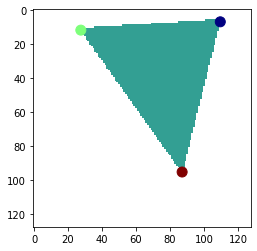

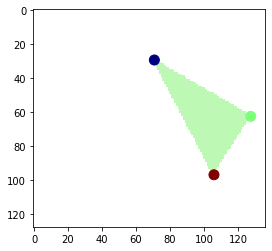

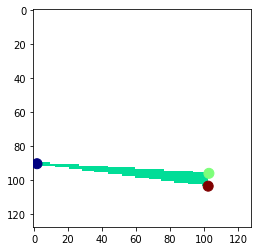

In [4]:
for idx in range(3):
    image, keypoints = generate_random_triangle()

    plt.imshow(image)
    plt.scatter(keypoints[..., 0],
                keypoints[..., 1],
                c=np.arange(3),
                s=100, cmap=plt.cm.jet, zorder=3)
    plt.show()

Now we'll generate the toy dataset and pass it to our `ToyGenerator` and then test that the generator is working

In [5]:
images, keypoints = generator_toy_data()

In [6]:
images.shape, keypoints.shape

((1000, 128, 128, 3), (1000, 3, 2))

In [7]:
generator = ToyGenerator(images, keypoints)

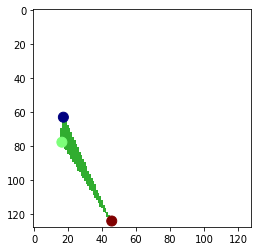

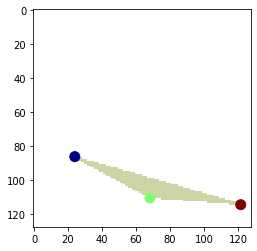

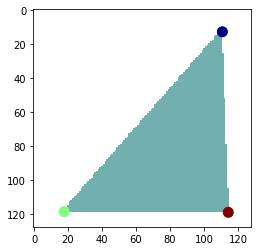

In [8]:
for idx in range(3):
    image, keypoints = generator[idx]

    plt.imshow(image[0])
    plt.scatter(keypoints[0, ..., 0],
                keypoints[0, ..., 1],
                c=np.arange(3),
                s=100, cmap=plt.cm.jet, zorder=3)
    plt.show()

Now we'll pass our `ToyGenerator` to the `TrainingGenerator` to get confidence maps.

In [14]:
train_generator = TrainingGenerator(generator=generator,
                                    downsample_factor=2,
                                    augmenter=None,
                                    sigma=3,
                                    validation_split=0.1, 
                                    use_graph=True,
                                    random_seed=1,
                                    graph_scale=1)
train_generator.get_config()

{'n_train': 900,
 'n_validation': 100,
 'validation_split': 0.1,
 'downsample_factor': 2,
 'output_shape': (32, 32),
 'n_output_channels': 8,
 'shuffle': True,
 'sigma': 3,
 'output_sigma': 0.75,
 'use_graph': True,
 'graph_scale': 1,
 'random_seed': 1,
 'augmenter': False,
 'generator': 'ToyGenerator',
 'n_samples': 1000,
 'image_shape': (128, 128, 3),
 'keypoints_shape': (3, 2)}

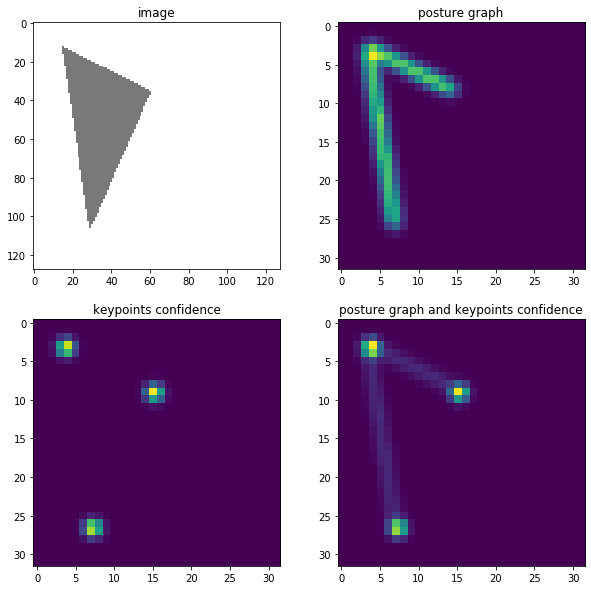

In [16]:
n_keypoints = generator.keypoints_shape[0]
batch = train_generator(batch_size=1, validation=False)[0]
inputs = batch[0]
outputs = batch[1]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
ax1.set_title('image')
ax1.imshow(inputs[0,...,0], cmap='gray', vmin=0, vmax=255)

ax2.set_title('posture graph')
ax2.imshow(outputs[0,...,n_keypoints:-1].max(-1), interpolation='none')

ax3.set_title('keypoints confidence')
ax3.imshow(outputs[0,...,:n_keypoints].max(-1), interpolation='none')

ax4.set_title('posture graph and keypoints confidence')
ax4.imshow(outputs[0,...,-1], vmin=0, interpolation='none')
plt.show()

train_generator.on_epoch_end()